# BERT for Domain Relevance Classification

`Melina Paxinou`

MA Linguistics, Text Mining - Vrije Universiteit Amsterdam

June 27, 2025

`Melina Paxinou    2854344`

## Imports and paths

In [365]:
from collections import Counter
from datasets import load_dataset
from evaluate import load
import pandas as pd
from datasets import Dataset
import numpy as np
from transformers import DataCollatorForTokenClassification
from transformers import set_seed
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
import transformers
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pickle
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import ast

In [367]:
# connect to GPU
device = torch.device('cuda')

print('Connected to GPU:', torch.cuda.get_device_name(0))

Connected to GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [520]:
train_file = '../baseline/train_sentences.tsv'
dev_file = '../baseline/dev_sentences.tsv'
test_file = '../baseline/test_sentences.tsv'
anno_file = '../baseline/anno_sentences.tsv'

In [522]:
train = pd.read_csv(train_file, sep="\t", header=0)
dev = pd.read_csv(dev_file, sep="\t", header=0)
test = pd.read_csv(test_file, sep="\t", header=0)
anno = pd.read_csv(anno_file, sep="\t", header=0)

In [524]:
train.head()

,sentence_number,sentence_tokens,target_token_index,is_metaphor,is_it_relevant,text_id
0,1,"['Epithelial', 'cells', '(', 'ECs', ')', 'at',...",21,1,1,3
1,1,"['Page', '4', 'of', '4', 'Mrs', 'Brown', 'said...",17,1,1,5
2,1,"['Following', 'administration', 'of', 'the', ""...",5,1,1,7
3,1,"['Anti', '-', 'GD2', 'CAR', 'NKT', 'cells', 'a...",46,1,1,8
4,1,"['Most', 'importantly', ',', 'this', 'approach...",23,1,1,9


## Statistics

In [527]:
def compute_statistics(df):
    sentence_col = 'sentence_number' if 'sentence_number' in df.columns else 'sentence_id'

    total_metaphors = len(df)

    relevant_metaphors = int(df['is_it_relevant'].sum())
        
    if 'text_id' in df.columns:
        total_sentences = df[['text_id', sentence_col]].drop_duplicates().shape[0]
    else:
        total_sentences = df[[sentence_col]].drop_duplicates().shape[0]
    
    print(f"Total metaphors: {total_metaphors}")
    print(f"Total relevant metaphors: {relevant_metaphors}")
    print(f"Total sentences: {total_sentences}")


In [528]:
compute_statistics(train)

Total metaphors: 536
Total relevant metaphors: 311
Total sentences: 453


In [529]:
compute_statistics(dev)

Total metaphors: 226
Total relevant metaphors: 97
Total sentences: 161


In [530]:
compute_statistics(test)

Total metaphors: 293
Total relevant metaphors: 112
Total sentences: 206


In [531]:
compute_statistics(anno)

Total metaphors: 50
Total relevant metaphors: 14
Total sentences: 22


## Loading the dataset

In [537]:
task = "relevant_metaphor_detection"
model_checkpoint = "bert-base-uncased"
batch_size = 16

In [539]:
# creating dataframes for train, dev, and test files

# defining column names for easier access to elements
column_names = [
 'sentence_number',	'sentence_tokens',	'target_token_index',	'is_metaphor',	'is_it_relevant',
    'text_id'
    ]

anno_column_names = [
        # "text_id",
        "sentence_number",
        'sentence_tokens',
        'target_token_index',
    'is_metaphor',
        "is_it_relevant",
    "text_id"
    ]



dev_df = pd.read_csv(
        dev_file,
        sep="\t",
        names=column_names,
        encoding="utf-8",
        header=0,
        na_filter=False, 
    )

train_df = pd.read_csv(
        train_file,
        sep="\t",
        names=column_names,
        encoding="utf-8",
        header=0,
        na_filter=False,
    )

test_df = pd.read_csv(
        test_file,
        sep="\t",
        names=column_names,
        encoding="utf-8",
        header=0,
        na_filter=False,
    )

anno_df = pd.read_csv(
        anno_file,
        sep="\t",
        names=anno_column_names,
        encoding="utf-8",
        header=0,
        # na_filter=False,
    )

In [ ]:
anno_df

## Preprocessing

In [544]:
import ast
import math

def clean_tokens(tokens_input):
    if not isinstance(tokens_input, str):
        tokens_input = str(tokens_input)

    try:
        tokens = ast.literal_eval(tokens_input)
        if not isinstance(tokens, list):
            tokens = [tokens]
    except Exception:
        tokens = tokens_input.split()

    cleaned_tokens = []
    for t in tokens:
        if isinstance(t, str):
            t_clean = t.strip("',\" ")
            if t_clean.lower() == 'nan' or t_clean.lower() == '':
                cleaned_tokens.append('[empty]')
            else:
                cleaned_tokens.append(t_clean)
        elif isinstance(t, float) and math.isnan(t):
            cleaned_tokens.append('[empty]')
        else:
            cleaned_tokens.append(str(t))

    return cleaned_tokens


def convert_df(df):
    examples = []

    for i, row in df.iterrows():
        if 'text_id' in df.columns and pd.notna(row.get('text_id')):
            sentence_id = f"{row['text_id']}_{row['sentence_number']}"
        else:
            sentence_id = str(row['sentence_number'])

        tokens = clean_tokens(row['sentence_tokens'])

        try:
            idx = int(row['target_token_index'])
            label = row['is_it_relevant']
        except Exception as e:
            raise ValueError(f"Row {i} has invalid index/label: {e}")

        labels = [-100] * len(tokens)
        if 0 <= idx < len(tokens):
            labels[idx] = label
            target_idx = idx
        else:
            target_idx = None

        examples.append({
            "id": sentence_id,
            "tokens": tokens,
            "labels": labels,
            "target_idx": target_idx,
        })

    return examples


In [545]:
dev_data = convert_df(dev_df)
train_data = convert_df(train_df)
test_data = convert_df(test_df)
anno_data = convert_df(anno_df)

In [ ]:
print(anno_data[1])

In [550]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [554]:
def tokenized_input_token_level(data, tokenizer, max_length=128):
    final_data = []

    for example in data:
        tokens = example["tokens"]
        labels = example["labels"]

        tokenized = tokenizer(
            tokens,
            is_split_into_words=True,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors=None,
        )

        word_ids = tokenized.word_ids()

        aligned_labels = []
        for word_idx in word_ids:
            if word_idx is None:
                aligned_labels.append(-100)  
            else:
                aligned_labels.append(labels[word_idx])

        tokenized_tokens = tokenizer.convert_ids_to_tokens(tokenized["input_ids"])

        final_data.append({
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"],
            "labels": aligned_labels,
            "word_ids": word_ids,
            "tokenized_tokens": tokenized_tokens,  
        })

    return final_data


In [556]:
train_tok = tokenized_input_token_level(train_data, tokenizer)
dev_tok = tokenized_input_token_level(dev_data, tokenizer)
test_tok = tokenized_input_token_level(test_data, tokenizer)
anno_tok = tokenized_input_token_level(anno_data, tokenizer)

In [ ]:
print(anno_tok[6])

In [560]:
def preprocess_example(example):
    """
    Takes as input a dictionary containing information of a training sentence and extracts the 
    necessary keys required for training. It ensures that only the relevant keys 
    (input_ids, attention_mask, and labels) are returned.

    Parameters:
    example (dictionary): A dictionary that contains the following keys:
    - 'input_ids': list of token IDs
    - 'attention_mask': mask for model
    - 'labels': labels for each token in the sequence

    Returns:
    A dictionary with only the following keys:
    - 'input_ids'
    - 'attention_mask'
    - 'labels'
    """
    return {
        "input_ids": example["input_ids"],
        "attention_mask": example["attention_mask"],
        "labels": example["labels"]
    }

In [561]:
# preprocessing the dataset
processed_train = [preprocess_example(example) for example in train_tok]
processed_dev = [preprocess_example(example) for example in dev_tok]
processed_test = [preprocess_example(example) for example in test_tok]
processed_anno = [preprocess_example(example) for example in anno_tok]

In [564]:
print(processed_test[6])

{'input_ids': [101, 2070, 6048, 2031, 2988, 4659, 2235, 16054, 1011, 29464, 2015, 1997, 9587, 7875, 2557, 5714, 23041, 14573, 6906, 7685, 2004, 18340, 3949, 2005, 5022, 2007, 3935, 1051, 10755, 2937, 4456, 2040, 2031, 3478, 7511, 3949, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -

## Fine-tuning the model

In [566]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=2) 
model.resize_token_embeddings(len(tokenizer))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(30522, 768, padding_idx=0)

In [671]:
SEED = 127
set_seed(SEED)

model_name = model_checkpoint
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",    
    eval_strategy = "epoch",    
    learning_rate=2e-5,    
    per_device_train_batch_size=batch_size,   
    per_device_eval_batch_size=batch_size,    
    num_train_epochs=8,    
    weight_decay=0.01,    
    seed=SEED,    
    report_to=None,    
    logging_dir='./logs',          
    logging_steps=10,    
)

In [673]:
max_len = max(
    max(len(sent['input_ids']) for sent in processed_train),
    max(len(sent['input_ids']) for sent in processed_dev),
    max(len(sent['input_ids']) for sent in processed_test),
    max(len(sent['input_ids']) for sent in processed_anno)
)

data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,      
    padding='max_length',     
    max_length=max_len        
)


In [675]:
metric = load("seqeval")

In [676]:
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=2)  
    labels = p.label_ids  
    
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()
    
    mask = labels_flat != -100
    preds_clean = preds_flat[mask]
    labels_clean = labels_flat[mask]

    precision, recall, f1, _ = precision_recall_fscore_support(labels_clean, preds_clean, average='binary')
    acc = accuracy_score(labels_clean, preds_clean)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}


In [678]:
def make_dataset(processed_doc):
    """
    Takes as input a processed document (list of dictionaries) and creates a dataset
    suitable for BERT training. It extracts the input IDs, attention masks, and labels from 
    each example in the processed list of dictionaries and organizes them into a dataset.

    Parameters:
    processed_doc (list of dictionaries): A list of dictionaries, where each dictionary contains:
    - 'input_ids': list of token IDs
    - 'attention_mask': attention mask for the model
    - 'labels': list of labels corresponding to each token 

    Returns:
    A dataset made with the datasets library containing:
    - 'input_ids'
    - 'attention_mask'
    - 'labels'
    """
    
    final_dataset = Dataset.from_dict({
        'input_ids': [example['input_ids'] for example in processed_doc],
        'attention_mask': [example['attention_mask'] for example in processed_doc],
        'labels': [example['labels'] for example in processed_doc]
    })
    return final_dataset

label_list = ['IRRELEVANT (0)' , 'RELEVANT (1)']

train_dataset = make_dataset(processed_train)
dev_dataset = make_dataset(processed_dev)
test_dataset = make_dataset(processed_test)
anno_dataset = make_dataset(processed_anno)

In [679]:
print(test_dataset[0])

{'input_ids': [101, 18540, 2475, 1031, 4064, 1033, 11311, 2291, 2573, 2004, 1037, 4721, 8803, 2011, 12151, 28927, 4442, 1998, 8650, 1996, 2303, 2114, 7870, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 1, -100, -100, -100, -100, -100, -10

In [682]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,    
    eval_dataset=dev_dataset,    
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

C:\Users\melou\AppData\Local\Temp\ipykernel_20516\2188118681.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [683]:
from pynvml import *
nvmlInit()
h = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(h)
print(f'total    : {info.total}')
print(f'free     : {info.free}')
print(f'used     : {info.used}')

total    : 8585740288
free     : 3150520320
used     : 5435219968


In [686]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA current device:", torch.cuda.current_device())
print("CUDA device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
CUDA device count: 1
CUDA current device: 0
CUDA device name: NVIDIA GeForce RTX 4070 Laptop GPU


In [689]:
# training
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.006100,0.425472,0.937500,0.870229,0.991304,0.926829
2,0.000300,0.200205,0.951389,0.904000,0.982609,0.941667
3,0.000000,0.157199,0.965278,0.933884,0.982609,0.957627
4,0.000000,0.160516,0.965278,0.933884,0.982609,0.957627
5,0.000000,0.164581,0.965278,0.933884,0.982609,0.957627
6,0.000000,0.167121,0.965278,0.933884,0.982609,0.957627
7,0.000000,0.168616,0.965278,0.933884,0.982609,0.957627
8,0.000000,0.169082,0.965278,0.933884,0.982609,0.957627


TrainOutput(global_step=272, training_loss=0.0004259974053264373, metrics={'train_runtime': 63.0867, 'train_samples_per_second': 67.97, 'train_steps_per_second': 4.312, 'total_flos': 280110123220992.0, 'train_loss': 0.0004259974053264373, 'epoch': 8.0})

In [690]:
# predicting
predictions, labels, _ = trainer.predict(anno_dataset)
predictions = np.argmax(predictions, axis=2)

In [691]:
# predicting on test
test_predictions, test_labels, _ = trainer.predict(test_dataset)
test_predictions = np.argmax(test_predictions, axis=2)

## Evaluation

In [694]:
trainer.evaluate()

{'eval_loss': 0.16908247768878937,
 'eval_accuracy': 0.9652777777777778,
 'eval_precision': 0.9338842975206612,
 'eval_recall': 0.9826086956521739,
 'eval_f1': 0.9576271186440678,
 'eval_runtime': 0.8754,
 'eval_samples_per_second': 258.173,
 'eval_steps_per_second': 17.135,
 'epoch': 8.0}

In [696]:
for idx, example in enumerate(anno_tok):
    example['prediction'] = predictions[idx].tolist()  
    example['gold'] = labels[idx].tolist()             


In [697]:
for idx, example in enumerate(test_tok):
    example['prediction'] = test_predictions[idx].tolist()  
    example['gold'] = test_labels[idx].tolist()             


In [ ]:
print(anno_tok[0])

In [ ]:
print(test_tok[0])

In [700]:
len(anno_tok)

50

In [701]:
len(test_tok)

293

In [702]:
def clean_and_group(data):
    special_tokens = ['[CLS]', '[SEP]', '[PAD]', '[UNK]', '[MASK]']

    word_ids = data['word_ids']
    predictions = data['prediction']
    gold = data['gold']
    tokens = data['tokenized_tokens']

    clean_word_ids = []
    clean_predictions = []
    clean_gold = []

    for token, wid, pred, g in zip(tokens, word_ids, predictions, gold):
        if token not in special_tokens and wid is not None:
            clean_word_ids.append(wid)
            clean_predictions.append(pred)
            clean_gold.append(g)

    grouped_preds = []
    grouped_gold = []
    current_wid = None
    temp_preds = []
    temp_gold = []

    for wid, pred, g in zip(clean_word_ids, clean_predictions, clean_gold):
        if wid != current_wid:
            if temp_preds:
                grouped_preds.append(temp_preds[0]) 
                grouped_gold.append(temp_gold[0])
            current_wid = wid
            temp_preds = [pred]
            temp_gold = [g]
        else:
            temp_preds.append(pred)
            temp_gold.append(g)

    if temp_preds:
        grouped_preds.append(temp_preds[0])
        grouped_gold.append(temp_gold[0])

    return grouped_preds, grouped_gold


In [703]:
all_preds = []
all_golds = []

for example in anno_tok:
    preds, golds = clean_and_group(example)
    all_preds.append(preds)
    all_golds.append(golds)


In [704]:
all_test_preds = []
all_test_golds = []

for example in test_tok:
    test_preds, test_golds = clean_and_group(example)
    all_test_preds.append(test_preds)
    all_test_golds.append(test_golds)


In [705]:
len(all_test_preds)

293

In [706]:
len(all_test_golds)

293

In [707]:
len(all_preds)

50

In [708]:
len(all_golds)

50

In [709]:
print(all_preds[8])
print()
print(all_golds[8])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

[-100, -100, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]


In [710]:
final_preds = []

for pred_sentence, gold_sentence in zip(all_preds, all_golds):
    for pred_label, gold_label in zip(pred_sentence, gold_sentence):
        if gold_label != -100:
            final_preds.append(pred_label)

flat_golds = []
for gold_sentence in all_golds:
    for g in gold_sentence:
        flat_golds.append(g)


In [711]:
final_test_preds = []

for test_pred_sentence, test_gold_sentence in zip(all_test_preds, all_test_golds):
    for test_pred_label, test_gold_label in zip(test_pred_sentence, test_gold_sentence):
        if test_gold_label != -100:
            final_test_preds.append(test_pred_label)

flat_test_golds = []
for test_gold_sentence in all_test_golds:
    for g in test_gold_sentence:
        flat_test_golds.append(g)


In [712]:
with open(anno_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

data_lines = lines[1:] 

num_valid_tokens = sum(1 for gold in flat_golds if gold != -100)

print(f"Lines in input file (excluding header): {len(data_lines)}")
print(f"Tokens with gold != -100 in gold labels: {num_valid_tokens}")
print(f"Length of final_preds: {len(final_preds)}")


Lines in input file (excluding header): 50
Tokens with gold != -100 in gold labels: 50
Length of final_preds: 50


In [713]:
with open(test_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

test_data_lines = lines[1:]  

test_num_valid_tokens = sum(1 for test_gold in flat_test_golds if test_gold != -100)

print(f"Lines in input file (excluding header): {len(test_data_lines)}")
print(f"Tokens with gold != -100 in gold labels: {test_num_valid_tokens}")
print(f"Length of final_preds: {len(final_test_preds)}")


Lines in input file (excluding header): 293
Tokens with gold != -100 in gold labels: 293
Length of final_preds: 293


In [714]:
def output_tsv_aligned(input_file, output_file, predictions, column_name="pred"):
    with open(input_file, "r", encoding="utf-8") as in_f:
        lines = [line.rstrip("\n") for line in in_f if line.strip()]

    header_line = lines[0]
    data_lines = lines[1:]

    if len(data_lines) != len(predictions):
        raise ValueError(f"Mismatch: {len(data_lines)} lines vs {len(predictions)} predictions.")

    original_columns = header_line.split("\t")
    new_columns = original_columns + [column_name]

    with open(output_file, "w", encoding="utf-8") as out_f:
        out_f.write("\t".join(str(col) for col in new_columns) + "\n")

        for line, pred_label in zip(data_lines, predictions):
            pred_token = 1 if pred_label == 1 else 0
            out_f.write(f"{line}\t{pred_token}\n")


In [715]:
output_tsv_aligned(anno_file,'./anno_bert_prediction.tsv', final_preds)

In [716]:
output_tsv_aligned(test_file,'./test_bert_prediction.tsv', final_test_preds)

We save the results in a .tsv file, which is then used to create the classification report and confusion matrix.

In [718]:
def evaluate_file(tsv_file):
    """
    Evaluate a TSV file with gold and predicted labels by creating a classification report and Confusion Matrix.

    Parameters:
    tsv_file: Path to the TSV file.

    Returns:
    None
    """

    columns = [
        "sentence_id",
        "sentence_tokens",
        "target_token_index",
        'is_metaphor',
        "is_it_relevant",
        "text_id",
        "pred"
    ]

    df = pd.read_csv(tsv_file, sep="\t", header=0, names=columns)

    y_true = df["is_it_relevant"].apply(lambda x: 0 if x == 0 else 1).tolist()
    y_pred = df["pred"].apply(lambda x: 0 if x == 0 else 1).tolist()

    report = classification_report(
        y_true, y_pred, labels=[0, 1], target_names=['IRRELEVANT (0)' , 'RELEVANT (1)'], digits=3
    )
    print("Classification Report (on metaphor tokens only):")
    print(report)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")

    target_names = ['IRRELEVANT (0)' , 'RELEVANT (1)']
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=target_names
    )
    disp.plot(cmap="magma_r")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

Classification Report (on metaphor tokens only):
                precision    recall  f1-score   support

IRRELEVANT (0)      0.944     0.472     0.630        36
  RELEVANT (1)      0.406     0.929     0.565        14

      accuracy                          0.600        50
     macro avg      0.675     0.700     0.597        50
  weighted avg      0.794     0.600     0.612        50

Confusion Matrix:


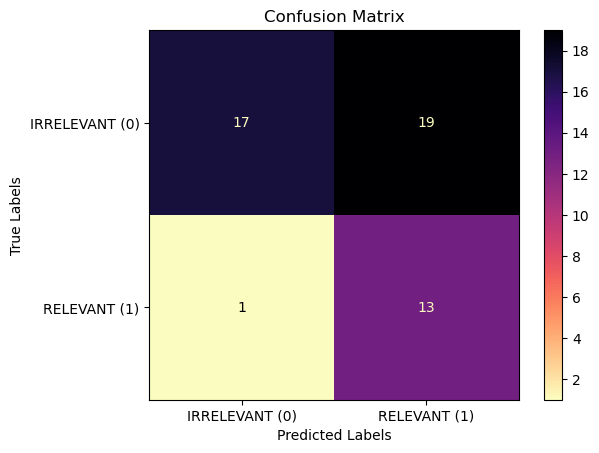

In [719]:
evaluate_file("anno_bert_prediction.tsv")

Classification Report (on metaphor tokens only):
                precision    recall  f1-score   support

IRRELEVANT (0)      0.958     0.890     0.923       181
  RELEVANT (1)      0.840     0.938     0.886       112

      accuracy                          0.908       293
     macro avg      0.899     0.914     0.904       293
  weighted avg      0.913     0.908     0.909       293

Confusion Matrix:


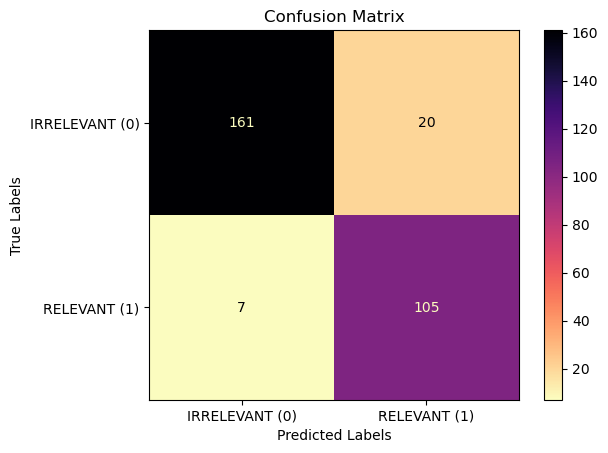

In [720]:
evaluate_file("test_bert_prediction.tsv")

In [721]:
def print_mismatched_output_lines(output_file):
    with open(output_file, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("target_token_index"):
                continue

            cols = line.split("\t")
            if len(cols) < 6:
                continue

            try:
                position = int(cols[2])
                token_str = cols[1].strip('"').replace('""', '"').replace('[empty]', '')
                tokens = ast.literal_eval(token_str)

                if isinstance(tokens, list):
                    tokens = ['[empty]' if t is None else t for t in tokens]
                else:
                    raise ValueError("Tokens not a list")

                classified_word = tokens[position] if 0 <= position < len(tokens) else "<INVALID_INDEX>"

            except Exception as e:
                classified_word = "<PARSE_ERROR>"

            gold = cols[4]       
            pred = cols[6]

            if gold == '1' and pred != '1':
                print(f"{line}")
                print(f"False negative: word='{classified_word}', pred={pred}, gold={gold}\n")
            elif pred != gold:
                print(f"{line}")
                print(f"Mismatch: word='{classified_word}', pred={pred}, gold={gold}\n")


In [ ]:
print_mismatched_output_lines('anno_bert_prediction.tsv')

In [ ]:
print_mismatched_output_lines('test_bert_prediction.tsv')

In [724]:
def show_misclassified_tokens(tsv_file):
    columns = [
        "sentence_number",
        "sentence_tokens",
        "token_text", 
        "metaphor",
        "is_it_relevant",
        "text_id",
        "pred"
    ]

    df = pd.read_csv(tsv_file, sep="\t", header=0, names=columns)

    df["is_it_relevant"] = df["is_it_relevant"].apply(lambda x: 1 if x == 1 else 0)
    df["pred"] = df["pred"].apply(lambda x: 1 if x == 1 else 0)

    df["token_text"] = df["token_text"].astype(int)

    df["tokens_list"] = df["sentence_tokens"].apply(lambda s: s.split())

    misclassified = df[df["is_it_relevant"] != df["pred"]].copy()

    misclassified["token_str"] = misclassified.apply(
        lambda row: row["tokens_list"][row["token_text"]]
        if row["token_text"] < len(row["tokens_list"])
        else "[INDEX_ERR]",
        axis=1
    )

    fp_rows = misclassified[
        (misclassified["is_it_relevant"] == 0) & (misclassified["pred"] == 1)
    ]
    fn_rows = misclassified[
        (misclassified["is_it_relevant"] == 1) & (misclassified["pred"] == 0)
    ]

    fp_tokens = fp_rows["token_str"].tolist()
    fn_tokens = fn_rows["token_str"].tolist()

    print(f"Number of misclassified metaphor tokens: {len(misclassified)}")
    print(f"\nFalse Positives ({len(fp_tokens)}):")
    for _, row in fp_rows.iterrows():
        print(f'[FP] Token: "{row["token_str"]}" | Sentence: {" ".join(row["tokens_list"])}\n')

    print(f"\nFalse Negatives ({len(fn_tokens)}):")
    for _, row in fn_rows.iterrows():
        print(f'[FN] Token: "{row["token_str"]}" | Sentence: {" ".join(row["tokens_list"])}\n')

    return fp_tokens, fn_tokens


In [ ]:
anno_fp, anno_fn = show_misclassified_tokens("anno_bert_prediction.tsv")

In [ ]:
print(anno_fp, '\n', anno_fn)

In [ ]:
test_fp, test_fn = show_misclassified_tokens("test_bert_prediction.tsv")

## Saving and loading the model

In [347]:
# model.save_pretrained("model_")

In [348]:
# tokenizer.save_pretrained("model_")

('model_\\tokenizer_config.json',
 'model_\\special_tokens_map.json',
 'model_\\vocab.txt',
 'model_\\added_tokens.json',
 'model_\\tokenizer.json')

In [351]:
# trainer.save_model("model_")  
# trainer.save_state()                      

In [353]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer

load_model = AutoModelForTokenClassification.from_pretrained("model_")
load_tokenizer = AutoTokenizer.from_pretrained("model_")
args = TrainingArguments(output_dir="model_")
load_trainer = Trainer(model=load_model, args=args, tokenizer=load_tokenizer)


C:\Users\melou\AppData\Local\Temp\ipykernel_20516\896808780.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  load_trainer = Trainer(model=load_model, args=args, tokenizer=load_tokenizer)


## Classifying a single sentence

In [357]:
from datasets import Dataset

def mega_function_v2(sentence_tokens, metaphor_idx, tokenizer, max_length=128):
    """
    Preprocess a single sentence for BERT input.
    Only one word (metaphor target) is labeled. All others get -100.

    Parameters:
    - sentence_tokens: List[str]
    - metaphor_idx: int (index of metaphor word)
    - tokenizer: HuggingFace tokenizer
    - max_length: int (for truncation and padding)

    Returns:
    - tokenized_data: list of dicts with tokenization details
    - final_dataset: HuggingFace Dataset with input_ids, attention_mask, labels
    """
    if metaphor_idx < 0 or metaphor_idx >= len(sentence_tokens):
        raise ValueError("Invalid metaphor_idx")
    raw_labels = [-100] * len(sentence_tokens)
    raw_labels[metaphor_idx] = 1

    tokenized = tokenizer(
        sentence_tokens,
        is_split_into_words=True,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors=None
    )

    word_ids = tokenized.word_ids()

    aligned_labels = []
    for word_id in word_ids:
        if word_id is None:
            aligned_labels.append(-100)
        else:
            aligned_labels.append(raw_labels[word_id])

    tokenized_data = [{
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "labels": aligned_labels,
        "word_ids": word_ids,
        "tokenized_tokens": tokenizer.convert_ids_to_tokens(tokenized["input_ids"])
    }]

    dataset = Dataset.from_dict({
        "input_ids": [tokenized["input_ids"]],
        "attention_mask": [tokenized["attention_mask"]],
        "labels": [aligned_labels]
    })

    return tokenized_data, dataset


In [359]:
from collections import Counter
import numpy as np

def transform_to_test_sentence_v4(example_dict, trainer, tokenizer, max_length=128):
    """
    Predict label for metaphor word in a sentence using token classification model.

    Parameters:
    - example_dict: {
        'sentence_tokens': List[str],
        'target_token_index': int
      }
    - trainer: HuggingFace Trainer
    - tokenizer: HuggingFace tokenizer

    Returns:
    - int: predicted label (0 or 1) for the target word
    """
    sentence_tokens = example_dict["sentence_tokens"]
    metaphor_idx = example_dict["target_token_index"]

    tokenized_data, dataset = mega_function_v2(
        sentence_tokens=sentence_tokens,
        metaphor_idx=metaphor_idx,
        tokenizer=tokenizer,
        max_length=max_length
    )

    predictions, _, _ = trainer.predict(dataset)
    pred_labels = np.argmax(predictions, axis=2)

    word_ids = tokenized_data[0]["word_ids"]
    token_preds = pred_labels[0]

    metaphor_token_predictions = [
        pred for wid, pred in zip(word_ids, token_preds) if wid == metaphor_idx
    ]

    if not metaphor_token_predictions:
        raise ValueError("No predictions found for metaphor token index.")

    majority_label = Counter(metaphor_token_predictions).most_common(1)[0][0]
    return majority_label


In [360]:
example = {
    "sentence_number": 101,
    "sentence_tokens": ['Her', 'immune', 'system', 'is', 'like', 'a', 'defence', 'barrier', '.'],
    "target_token_index": 7
}

preds = transform_to_test_sentence_v4(example, load_trainer, load_tokenizer)
print(preds)

if preds == 1:
    metaphor_scope = example["sentence_tokens"][example["target_token_index"]]
else:
    metaphor_scope = ''

print(metaphor_scope)

1
barrier
